In [1]:
library(MASS)
library(e1071)
library(class)
setwd("D:/OneDrive - University of Florida/Courses/2019 Spring/STA 6707/Project/Data")

Warning message:
"package 'MASS' was built under R version 3.5.2"Warning message:
"package 'e1071' was built under R version 3.5.3"Warning message:
"package 'class' was built under R version 3.5.3"

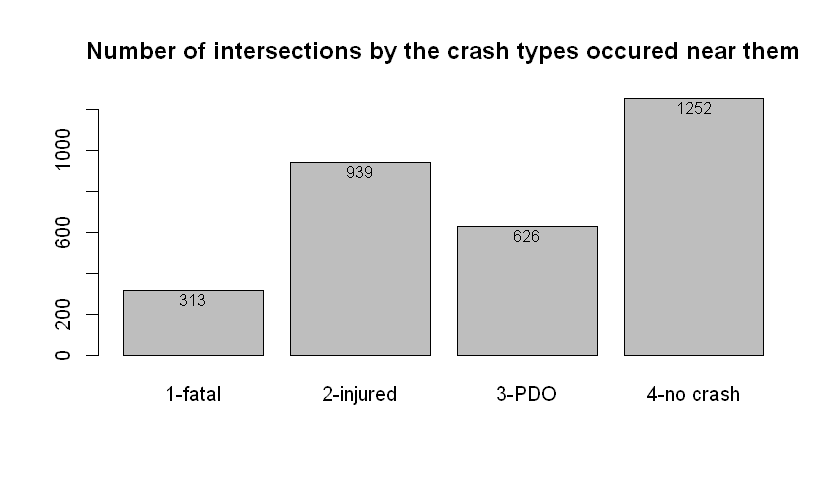

In [2]:
options(repr.plot.width=7, repr.plot.height=4)
crash.logdata <- readRDS("Data_log_Sample_0418.Rda")
crash.data <- readRDS("Data_Sample_0418.Rda")
bp <-barplot(
    summary(crash.data$Y.f), names.arg=c("1-fatal", "2-injured", "3-PDO", "4-no crash"),
    main="Number of intersections by the crash types occured near them"
)
text(bp, summary(crash.data$Y.f)-40, labels=summary(crash.data$Y.f), cex=.8)

***Remove categorical variables for LDA, QDA, KNN, and Naive Bayes***

In [3]:
crash.logdata.numonly <- crash.logdata[
    , c(FALSE, FALSE, TRUE, !sapply(crash.logdata[,4:ncol(crash.logdata)], is.factor))
]
head(crash.logdata.numonly)

Y.f,LU.res.log,LU.arg.log,LU.ret.log,LU.com.log,LU.ent.log,LU.ser.log,LU.ind.log,LU.ins.log,LU.rec.log,LU.oth.log,AADT.max.log,AADT.min.log,AADT.avg.log,AADT.diff.log,Int.Angle.log,Loc.Dist.Curve.log,Loc.Dist.Int.log
1,1.158894e-01,0.6026579,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.048942584,7.937732,5.017280,7.401842,7.882692,4.510860,6.821211,6.705755
1,5.398903e-02,0.6619995,0.000000000,0.000000000,0,0.005845042,0.000000000,0.00000000,0,0.000000000,6.621406,6.311735,6.478510,5.303305,4.510860,7.341346,6.399959
1,1.329079e-01,0.6194227,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.000000000,6.857514,2.995732,6.206576,6.837333,4.401829,0.000000,3.767326
1,2.609966e-05,0.6857607,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.014585669,7.937732,2.564949,7.229114,7.933438,4.510860,6.806593,6.689333
1,2.891719e-01,0.4579607,0.001191155,0.001784079,0,0.000000000,0.009940649,0.06018127,0,0.008796244,8.389587,6.311735,7.829233,8.256088,4.122284,4.829027,3.222439
1,1.029120e-01,0.5424737,0.000000000,0.000000000,0,0.000000000,0.007137703,0.00000000,0,0.152021971,8.216358,6.552508,7.901377,8.006701,4.335983,0.000000,3.683016


In [4]:
crash.data.numonly <- crash.data[
    , c(FALSE, FALSE, TRUE, !sapply(crash.data[,4:ncol(crash.data)], is.factor))
]
head(crash.data.numonly)

Y.f,LU.res,LU.arg,LU.ret,LU.com,LU.ent,LU.ser,LU.ind,LU.ins,LU.rec,LU.oth,AADT.max,AADT.min,AADT.avg,AADT.diff,Int.Angle,Loc.Dist.Curve,Loc.Dist.Int
1,0.12287168,0.8269683,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.050160053,2800,150,1638,2650,90.0,916.0948,816.09476
1,0.05547302,0.9386648,0.000000000,0.000000000,0,0.005862158,0.000000000,0.00000000,0,0.000000000,750,550,650,200,90.0,1541.7880,600.82020
1,0.14214478,0.8578552,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.000000000,950,19,495,931,80.6,0.0000,42.26423
1,0.00002610,0.9852814,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000,0,0.014692559,2800,12,1378,2788,90.0,902.7862,802.78624
1,0.33532129,0.5808469,0.001191865,0.001785671,0,0.000000000,0.009990221,0.06202904,0,0.008835045,4400,550,2512,3850,60.7,124.0892,24.08923
1,0.10839387,0.7202571,0.000000000,0.000000000,0,0.000000000,0.007163237,0.00000000,0,0.164185814,3700,700,2700,3000,75.4,0.0000,38.76615


### 1. LDA with 5-fold cross validation

In [5]:
cv.lda <- 
  function (data, model, yname, numclass=4, K=5, seed=123) {
    n <- nrow(data)
    set.seed(seed)
    datay = data[, yname]
    f <- ceiling(n/K)
    s <- sample(rep(1:K, f), n)
    
    CV <- NULL
    crashy <- NULL
    modely <- NULL
    classerror <- NULL
    
    for (i in 1:K) {
      lda.fit <- lda(model, data=data[s!=i,])
      lda.y <- data[s==i, yname]
      lda.predy <- predict(lda.fit, data[s==i,])$class
      error <- mean(lda.y!=lda.predy)
      crashy <- c(crashy, lda.y)
      modely <- c(modely, lda.predy)
      CV <- c(CV, error)
    }
    
    confmtx <- table(crashy, modely)
    for (i in 1:numclass) {
      classerror <- c(classerror, rowSums(confmtx[,-i])[i] / rowSums(confmtx)[i])
    }
    
    list(K=K, knn_error_rate=mean(CV), seed=seed, confusion_matrix=confmtx, class_specific_error=classerror)
  }


In [6]:
cv.lda(crash.logdata.numonly, Y.f~., "Y.f")

$K
[1] 5

$knn_error_rate
[1] 0.5140575

$seed
[1] 123

$confusion_matrix
      modely
crashy    1    2    3    4
     1   34  189    2   88
     2   32  475    5  427
     3    6  238    5  377
     4    6  238    1 1007

$class_specific_error
        1         2         3         4 
0.8913738 0.4941427 0.9920128 0.1956869 


### 2. QDA with 5-fold cross validation 

In [7]:
cv.qda <- 
  function (data, model, yname, numclass=4, K=5, seed=123) {
    n <- nrow(data)
    set.seed(seed)
    datay = data[, yname]
    f <- ceiling(n/K)
    s <- sample(rep(1:K, f), n)
    
    CV <- NULL
    crashy <- NULL
    modely <- NULL
    classerror <- NULL
    
    for (i in 1:K) {
      qda.fit <- qda(model, data=data[s!=i,])
      qda.y <- data[s==i, yname]
      qda.predy <- predict(qda.fit, data[s==i,])$class
      error <- mean(qda.y!=qda.predy)
      crashy <- c(crashy, qda.y)
      modely <- c(modely, qda.predy)
      CV <- c(CV, error)
    }
      
    confmtx <- table(crashy, modely)
    for (i in 1:numclass) {
      classerror <- c(classerror, rowSums(confmtx[,-i])[i] / rowSums(confmtx)[i])
    }
    
    list(K=K, knn_error_rate=mean(CV), seed=seed, confusion_matrix=confmtx, class_specific_error=classerror)
  }

In [8]:
cv.qda(crash.logdata.numonly, Y.f~., "Y.f")

$K
[1] 5

$knn_error_rate
[1] 0.5853035

$seed
[1] 123

$confusion_matrix
      modely
crashy    1    2    3    4
     1   76   36   31  170
     2   88   90  126  635
     3   33   51   77  465
     4   35   38  124 1055

$class_specific_error
        1         2         3         4 
0.7571885 0.9041534 0.8769968 0.1573482 


### 3. Naive Bayes with 5-fold cross vaidation

In [9]:
cv.naiveBayes <- 
  function (data, model, yname, numclass=4, K=5, seed=123) {
    n <- nrow(data)
    set.seed(seed)
    datay = data[, yname]
    f <- ceiling(n/K)
    s <- sample(rep(1:K, f), n)
    
    CV <- NULL
    crashy <- NULL
    modely <- NULL
    classerror <- NULL
    
    for (i in 1:K) {
      naiveBayes.fit <- naiveBayes(model, data=data[s!=i,])
      naiveBayes.y <- data[s==i, yname]
      naiveBayes.predy <- predict(naiveBayes.fit, data[s==i,])
      error <- mean(naiveBayes.y!=naiveBayes.predy)
      crashy <- c(crashy, naiveBayes.y)
      modely <- c(modely, naiveBayes.predy)
      CV <- c(CV, error)
    }
      
    confmtx <- table(crashy, modely)
    for (i in 1:numclass) {
      classerror <- c(classerror, rowSums(confmtx[,-i])[i] / rowSums(confmtx)[i])
    }
    
    list(K=K, knn_error_rate=mean(CV), seed=seed, confusion_matrix=confmtx, class_specific_error=classerror)
  }

In [10]:
cv.naiveBayes(crash.logdata.numonly, Y.f~., "Y.f")

$K
[1] 5

$knn_error_rate
[1] 0.5884984

$seed
[1] 123

$confusion_matrix
      modely
crashy    1    2    3    4
     1   96   31   43  143
     2  160   84  163  532
     3   62   43  101  420
     4   54   42  149 1007

$class_specific_error
        1         2         3         4 
0.6932907 0.9105431 0.8386581 0.1956869 


### 4. Nearest Neighbor with 5-fold cross validation

In [11]:
cv.knn <- 
  function (data, yname, k, numclass=4, cvfold=5, seed=123) {
    n <- nrow(data)
    set.seed(seed)
    datay = data[, yname]
    f <- ceiling(n/cvfold)
    s <- sample(rep(1:cvfold, f), n)
    
    CV <- NULL
    crashy <- NULL
    modely <- NULL
    classerror <- NULL
      
    for (i in 1:cvfold) {
      knn.predy <- knn(data[s!=i,-1], data[s==i,-1], data[s!=i,yname], k=k)
      knn.y <- data[s==i, yname]
      error <- mean(knn.predy!=data[s==i,yname])
      crashy <- c(crashy, knn.y)
      modely <- c(modely, knn.predy)
      CV <- c(CV, error)
    }
    confmtx <- table(crashy, modely)
    for (i in 1:numclass) {
      classerror <- c(classerror, rowSums(confmtx[,-i])[i] / rowSums(confmtx)[i])
    }
    
    list(K=cvfold, knn_error_rate=mean(CV), seed=seed, confusion_matrix=confmtx, class_specific_error=classerror)
  }

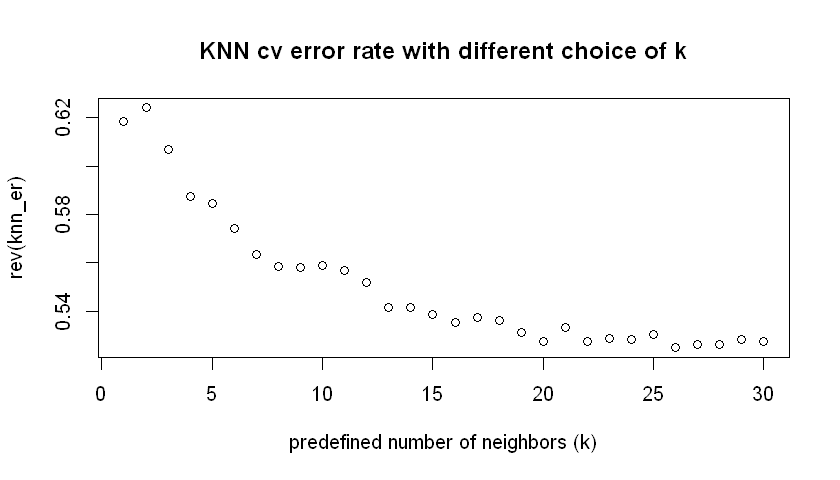

In [12]:
knn_er <- NULL
for (i in 1:30) {
    knn_er <- c(cv.knn(crash.logdata.numonly, "Y.f", i)$knn_error_rate, knn_er)
}
plot(1:30, rev(knn_er), xlab="predefined number of neighbors (k)", main="KNN cv error rate with different choice of k")

In [13]:
cv.knn(crash.logdata.numonly, "Y.f", 20)

$K
[1] 5

$knn_error_rate
[1] 0.527476

$seed
[1] 123

$confusion_matrix
      modely
crashy   1   2   3   4
     1  45 152  22  94
     2  41 380  56 462
     3  12 167  59 388
     4  10 171  76 995

$class_specific_error
        1         2         3         4 
0.8562300 0.5953142 0.9057508 0.2052716 


### REMOVE THE CLASS 4 (no crash)

In [14]:
crash.logdata.3class <- crash.logdata.numonly[
    (crash.logdata.numonly$Y.f!=4),
]
crash.logdata.3class$Y.f <- factor(crash.logdata.3class$Y.f)

In [15]:
cv.lda(crash.logdata.3class, Y.f~., "Y.f", numclass=3)

$K
[1] 5

$knn_error_rate
[1] 0.4941631

$seed
[1] 123

$confusion_matrix
      modely
crashy   1   2   3
     1  32 255  26
     2  26 794 119
     3   4 498 124

$class_specific_error
        1         2         3 
0.8977636 0.1544196 0.8019169 


In [16]:
cv.qda(crash.logdata.3class, Y.f~., "Y.f", numclass=3)

$K
[1] 5

$knn_error_rate
[1] 0.6075333

$seed
[1] 123

$confusion_matrix
      modely
crashy   1   2   3
     1  82  56 175
     2 113 129 697
     3  32  68 526

$class_specific_error
        1         2         3 
0.7380192 0.8626198 0.1597444 


In [17]:
cv.naiveBayes(crash.logdata.3class, Y.f~., "Y.f", numclass=3)

$K
[1] 5

$knn_error_rate
[1] 0.6224454

$seed
[1] 123

$confusion_matrix
      modely
crashy   1   2   3
     1  97  47 169
     2 178 121 640
     3  57  78 491

$class_specific_error
        1         2         3 
0.6900958 0.8711395 0.2156550 


In [18]:
cv.knn(crash.logdata.numonly, "Y.f", 20, numclass=3)

$K
[1] 5

$knn_error_rate
[1] 0.527476

$seed
[1] 123

$confusion_matrix
      modely
crashy   1   2   3   4
     1  45 152  22  94
     2  41 380  56 462
     3  12 167  59 388
     4  10 171  76 995

$class_specific_error
        1         2         3 
0.8562300 0.5953142 0.9057508 
